In [1]:
import sklearn.datasets
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import csv
import os
import yaml

from models import MLP
from helpers import rotate, plot_decision_boundary, load_model

In [2]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

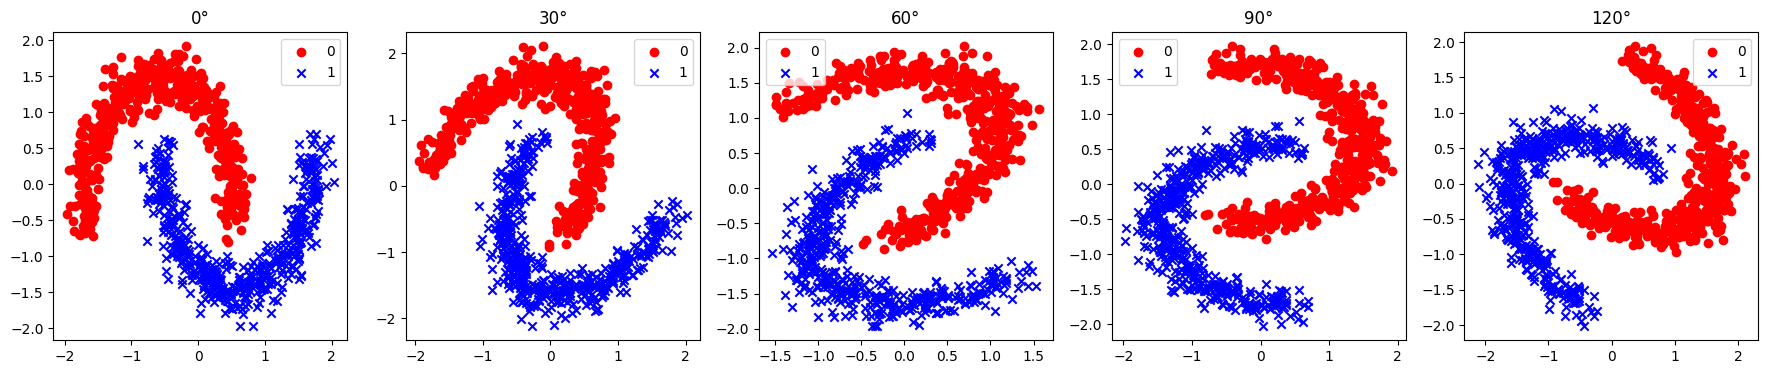

In [3]:
# Vizualization of different rotations
angles = [0, 30, 60, 90, 120]

fig, ax = plt.subplots(1, 5, figsize=(22, 4))

for i, angle in enumerate(angles):
    X_rotated = rotate(X, angle)
    ax[i].scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
    ax[i].scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')
    ax[i].legend(["0","1"])
    ax[i].set_title(f"{angle}°")

plt.show()

In [5]:
if(not os.path.exists("models")):
    os.makedirs("models")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}")

Current device: cuda:0


In [5]:
dataset_name = "two_angles"

if(not os.path.exists(f"models/{dataset_name}")):
    os.makedirs(f"models/{dataset_name}")

    # Hyperparameters
    angles = list(range(0, 360, 5))
    angles = [0, 90]
    models_per_angle = 2000
    epochs = 500
    learning_rate = 0.01

    # Logging
    torch.manual_seed(42)
    logs = []
    models_path = "models"

    # Training
    for angle in tqdm(angles):
        for i in range(models_per_angle):
            model = MLP()
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            X_rotated = rotate(X, angle)
            X_tensor = torch.tensor(X_rotated, dtype=torch.float32)
            y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

            for epoch in range(epochs):
                y_pred = model(X_tensor)
                loss = criterion(y_pred, y_tensor)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()


            model.eval()
            y_pred = model(X_tensor).detach().numpy().round().flatten()
            correct = (y_pred == y).sum()
            accuracy = correct / len(y) * 100
            logs.append([angle, i, accuracy])

            torch.save(model.state_dict(), f"{models_path}/{dataset_name}/model_{angle}_{i}.pth")


    with(open("logs.csv", "w")) as f:
        writer = csv.writer(f, lineterminator = '\n')
        writer.writerow(["angle", "model", "accuracy"])
        writer.writerows(logs)

In [105]:
dataset_name = "four_angles"

if(not os.path.exists(f"models/{dataset_name}")):
    os.makedirs(f"models/{dataset_name}")

    # Hyperparameters
    angles = list(range(0, 360, 5))
    angles = [0, 90, 180, 270]
    models_per_angle = 2000
    epochs = 60
    learning_rate = 0.05

    # Logging
    torch.manual_seed(42)
    logs = []
    models_path = "models"

    # Training
    for angle in tqdm(angles):
        for i in tqdm(range(models_per_angle), leave=False):
            model = MLP()
            model.to(device)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            X_rotated = rotate(X, angle)
            X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32).to(device)
            for epoch in range(epochs):
                y_pred = model(X_tensor)
                loss = criterion(y_pred, y_tensor)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()


            model.eval()
            y_pred = model(X_tensor).cpu().detach().numpy().round().flatten()
            correct = (y_pred == y).sum()
            accuracy = correct / len(y) * 100
            logs.append([angle, i, accuracy])

            torch.save(model.state_dict(), f"{models_path}/{dataset_name}/model_{angle}_{i}.pth")


    with(open(f"logs_{dataset_name}.csv", "w")) as f:
        writer = csv.writer(f, lineterminator = '\n')
        writer.writerow(["angle", "model", "accuracy"])
        writer.writerows(logs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

100.0


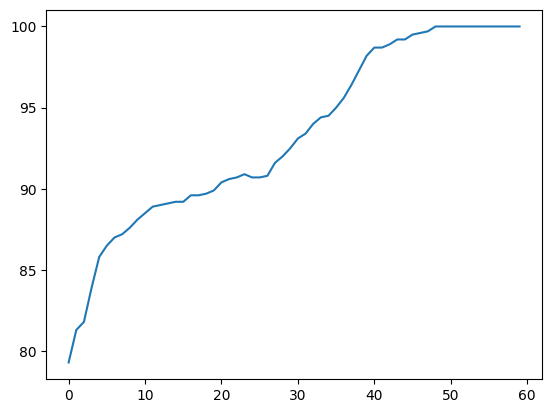

In [102]:
import matplotlib.pyplot as plt
# Hyperparameters
epochs = 60
learning_rate = 0.05

# Logging
logs = []
models_path = "Models"

# Training
model = MLP()
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

X_rotated = rotate(X, 0)
X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32).to(device)
for epoch in range(epochs):
    model.train()
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    y_pred = model(X_tensor).cpu().detach().numpy().round().flatten()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    logs.append(accuracy)

print(logs[-1])
plt.plot(logs)
plt.show()


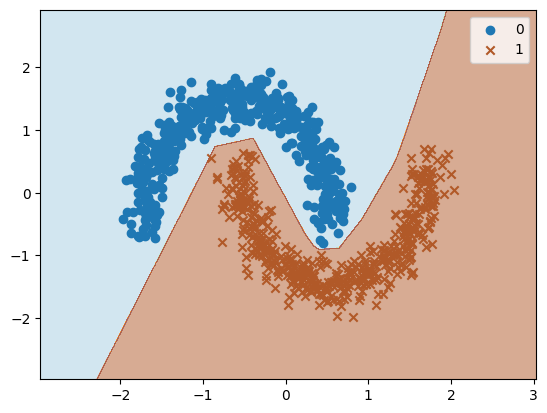

In [90]:
plot_decision_boundary(model, rotate(X,0), y)